# Analyze and plot methods for hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0
##### date: 14 December 2021

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model
from custom_loss import compute_shash_NLL, compute_NLL
from custom_metrics import CustomMAE, InterquartileCapture, SignTest
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from tensorflow.keras import optimizers
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp

from tqdm import tqdm

silence_tensorflow()

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "14 December 2021"

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load the models

In [5]:
EXP_NAME_LIST = ("intensity0_AL72","intensity1_AL72")

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    # pprint.pprint(settings, width=80)
    
    NETWORK_SEED_LIST = [settings["rng_seed"]]
    network_seed = NETWORK_SEED_LIST[0]
    tf.random.set_seed(network_seed)  # This sets the global random seed.    
    
    (x_train,
        onehot_train,
        x_val,
        onehot_val,
        data_summary,
        df,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=0)    

    # Create the model name.
    model_name = (
        exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
    )
    pprint.pprint(model_name)

    if settings["uncertainty_type"] == "bnn":       
        model_bnn = build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_bnn.load_weights(MODEL_PATH + model_name + "_weights.h5")

    elif settings["uncertainty_type"][:5] == "shash":   
        model_shash = build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_shash.load_weights(MODEL_PATH + model_name + "_weights.h5")


'intensity0_AL72_shash3_network_seed_888_rng_seed_888'
'intensity1_AL72_bnn_network_seed_888_rng_seed_888'


/opt/anaconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/opt/anaconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


## Make Model Predictions

In [6]:
runs = 500
shash_cpd = np.zeros((np.shape(x_val)[0],runs))
bnn_cpd = np.zeros((np.shape(x_val)[0],runs))
tf.random.set_seed(network_seed)

for j in tqdm(range(0,np.shape(shash_cpd)[0])):
    #shash calculation
    shash_pred = model_shash.predict(x_val[j])
    (mu_pred, sigma_pred, gamma_pred) = (shash_pred[:,0], shash_pred[:,1], shash_pred[:,2])
    shash_cpd[j,:] = shash.rvs(mu_pred,sigma_pred,gamma_pred,np.ones(np.shape(mu_pred)),size=runs)
    
for i in tqdm(range(0,runs)):
    # bnn calculation
    bnn_cpd[:,i] = np.reshape(model_bnn.predict(x_val),np.shape(bnn_cpd)[0])
     

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 29.19it/s]


## Plot Results

In [7]:
### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([]) 

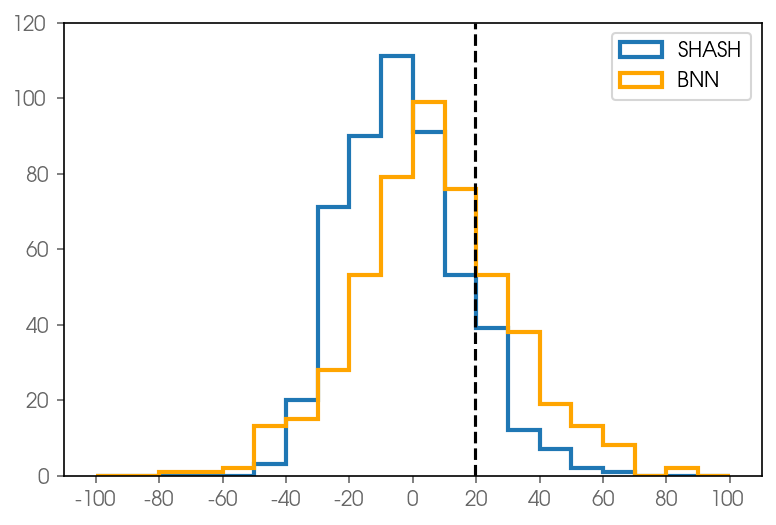

In [8]:
# PLOT RESULTS    
sample_index = 5
bins = np.arange(-100,110,10)

ax = plt.figure()
# results for SHASH
clr = 'tab:blue'
plt.hist(shash_cpd[sample_index,:],
         bins=bins,
         histtype=u'step',
         density=False, 
         color=clr,
         linewidth=2, 
         label='SHASH',         
        )

# results for BNN
clr = 'orange'
plt.hist(bnn_cpd[sample_index,:],
         bins=bins,
         histtype=u'step',
         density=False, 
         color=clr,
         linewidth=2,
         label='BNN',
        )

# truth
plt.axvline(x=onehot_val[sample_index,0],color='k',linestyle='--')
    
plt.legend()

ax = plt.gca()
plt.xticks(bins[::2],bins[::2])
yticks = ax.get_yticks()
plt.yticks(yticks.astype(int),yticks.astype(int))

plt.show()